### This notebook serves as an introduction to the wind power data of the GEFCom2014 data set

Specifically, we'll read the wind power data from GEFCom2014 and check them for anomalies with the [OpenOA](https://github.com/NREL/OpenOA) library developed by NREL. As an example, we'll also fit several power curves.

The raw training data are organized in a folder ../data/GEFCom2014/Wind/Task x/Taskx_W_Zone1_10.zip and testing data ../data/GEFCom2014/Wind/Task x/TaskExpVarsx_W_Zone1_10.zip, where x stands for the task number.

Since the final task includes all data (including the final month in "Solution"), we extract the data from this folder.

In [31]:
import os
import pandas as pd
import glob
from natsort import os_sorted
import numpy as np
import matplotlib.pyplot as plt

from operational_analysis.toolkits import filters
from operational_analysis.toolkits import power_curve

PATH = "/Users/dennis.van_der_meer/Documents/Projects/ConformalPrediction/data/GefCom2014/wind/"

### Start by reading the exogenous data from all the zones for the last month (2013-12) of the data set

Then, read the target variables and join these dataframes on zone ID and time stamp.

In [2]:
# List and sort the csv files of the exogenous data
files = os_sorted(glob.glob(os.path.join(PATH, "*ExpVars*.csv")))

In [3]:
# Read the exogenous data of Task 15 for all 10 zones for the final month
lst = []
for file in files:
    df = pd.read_csv(file, index_col = ["TIMESTAMP", "ZONEID"], parse_dates = True)
    df['WS10'] = np.sqrt(df['U10']**2 + df['V10']**2)
    df['WS100'] = np.sqrt(df['U100']**2 + df['V100']**2)
    df['WD10'] = np.mod(180 + 180/np.pi * np.arctan2(df['V10'], df['U10']), 360)
    df['WD100'] = np.mod(180 + 180/np.pi * np.arctan2(df['V100'], df['U100']), 360)
    df = df.drop(['U10', 'V10', 'U100', 'V100'], axis=1)
    lst.append(df)
df = pd.concat(lst)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [4]:
# Read the target data of Task 15 for the final month
file = os.path.join(PATH, "solution15_W.csv")
solutions = pd.read_csv(file, index_col = ["TIMESTAMP", "ZONEID"], parse_dates = True)

In [5]:
# Join the exogenous variables and target data of Task 15 for the final month
tmp = df.merge(solutions, how = 'left', left_index = True, right_index = True)

### The next step is to read the data preceding the previous data, which already has target and exogenous variables combined

However, we still need to convert U and V components to wind speed and wind direction.

In [6]:
# List and sort the csv files of the exogenous and target data
files = os_sorted(glob.glob(os.path.join(PATH, "Task15_*.csv")))

In [7]:
# Read the exogenous data of Task 15 for all 10 zones for the final month
lst = []
for file in files:
    df = pd.read_csv(file, index_col = ["TIMESTAMP", "ZONEID"], parse_dates = True)
    df['WS10'] = np.sqrt(df['U10']**2 + df['V10']**2)
    df['WS100'] = np.sqrt(df['U100']**2 + df['V100']**2)
    df['WD10'] = np.mod(180 + 180/np.pi * np.arctan2(df['V10'], df['U10']), 360)
    df['WD100'] = np.mod(180 + 180/np.pi * np.arctan2(df['V100'], df['U100']), 360)
    df = df.drop(['U10', 'V10', 'U100', 'V100'], axis=1)
    lst.append(df)
df = pd.concat(lst)

### Now it is possible to concatenate the data frames so that there's a continuous data set for 2012-2013

Note that there are missing target values (although not that many) so there's also groupwise linear interpolation to deal with these.

In [8]:
dat = pd.concat([df, tmp])
print(dat.isna().sum())
dat = dat.groupby('ZONEID').apply(lambda group: group.interpolate(method = 'linear', limit_direction = 'both'))
print(dat.isna().sum())

TARGETVAR    175
WS10           0
WS100          0
WD10           0
WD100          0
dtype: int64
TARGETVAR    0
WS10         0
WS100        0
WD10         0
WD100        0
dtype: int64


### Let's plot the wind power versus the predicted (!) wind speed to see if there are no obvious anomalies in the data that we might want to filter out

/opt/anaconda3/envs/conformalprediction/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1041: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<AxesSubplot: xlabel='WS100', ylabel='TARGETVAR'>

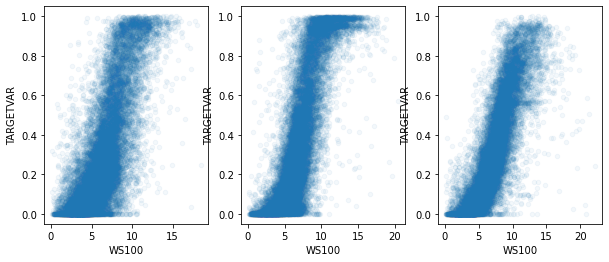

In [9]:
fig, ax = plt.subplots(ncols=3, figsize=(10,4))

dat.xs(1, level = 1, drop_level = False).plot.scatter(x = 'WS100', y = 'TARGETVAR', ax=ax[0], alpha = 0.05)
dat.xs(4, level = 1, drop_level = False).plot.scatter(x = 'WS100', y = 'TARGETVAR', ax=ax[1], alpha = 0.05)
dat.xs(7, level = 1, drop_level = False).plot.scatter(x = 'WS100', y = 'TARGETVAR', ax=ax[2], alpha = 0.05)

### It doesn't seem like there are obvious outliers but we can use [OpenOA](https://github.com/NREL/OpenOA) to flag suspicious data and potentially filter them out.

OpenOA offers a number of filters such as the range filter, window range filter, bin filter or unresponsive filter that we'll use here.

From here on, we consider only the first zone but the idea can obviously be extended to the other zones as well.

In [10]:
windspeed = dat.xs(1, level = 1, drop_level = True)["WS100"]
power = dat.xs(1, level = 1, drop_level = True)["TARGETVAR"]

In [11]:
# To plot flagged instances
def plot_flagged_pc(ws, p, flag_bool, alpha):
    plt.scatter(ws, p, s = 1, alpha = alpha)
    plt.scatter(ws[flag_bool], p[flag_bool], s = 1, c = 'red')
    plt.xlabel('Wind speed (m/s)')
    plt.ylabel('Power (-)')
    plt.show()

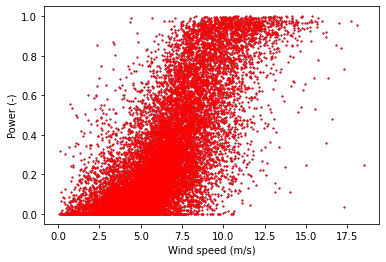

In [12]:
# Plot the raw power data again but with the above function
plot_flagged_pc(windspeed, power, np.repeat(True, power.shape[0]), 1)

### Range filter

In [13]:
out_of_range = filters.range_flag(windspeed, below=0, above=70)
windspeed[out_of_range].head()

Series([], Name: WS100, dtype: float64)

No wind speed out of range.

### Window range filter

Next, we'll apply a window range filter to remove data with normalized power values outside of the window from 0.01 to 1.05 kW for wind speeds between 5 and 40 m/s.

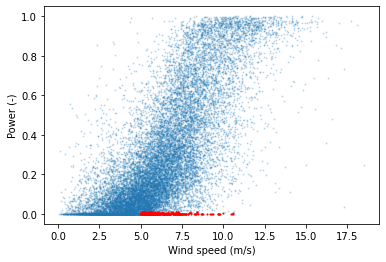

In [14]:
out_of_window = filters.window_range_flag(windspeed, 5., 40, power, 0.01, 1.05)
plot_flagged_pc(windspeed, power, out_of_window, 0.2)

Let's remove these values from consideration

In [15]:
windspeed_filt1 = windspeed[~out_of_window]
power_filt1 = power[~out_of_window]

### Bin filter

We can also bin the data and flag data points that deviate too much (scalar or standard deviation) from the mean or median of the bin center. This requires defining the bin width, as well as the start and end points of the bins.

Here, we bin the power in 2.5% increments, starting at 1% and stopping at 90% of peak power. We use a scalar threshold of 3.0 m/s from each bin's median. It's worth reiterating that the wind speed data aren't measurements but forecasts and come with their own uncertainty. Therefore, we set the threshold quite high. Finally, we consider data on both sides of the curve by setting the 'direction' parameter to 'all'.

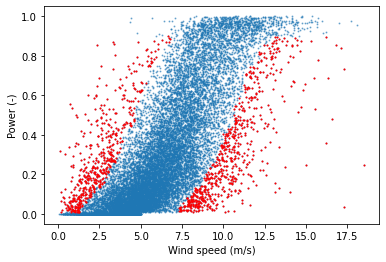

In [16]:
bin_outliers = filters.bin_filter(power_filt1, windspeed_filt1, 0.025, 3., 'median', 0.01, 0.9, 'scalar', 'all')
plot_flagged_pc(windspeed_filt1, power_filt1, bin_outliers, 0.5)

In [17]:
windspeed_filt2 = windspeed_filt1[~bin_outliers]
power_filt2 = power_filt1[~bin_outliers]

Setting the threshold value can be tricky when dealing with wind speed forecasts, so a bit of experimentation with this value may be necessary!

### Unresponsive filter

Finally, we can check for an unrespsonsive sensor (i.e. repeating measurements). In the example provided by OpenOA, they look for repeating wind speed measurements. However, in this example we don't have wind speed measurements but wind speed forecasts and repeating values are therefore unlikely. Therefore, we ignore this filter in this example.

### Power curve fitting

Use three power curve models that OpenOA provides:

In [18]:
# Fit the power curves
iec_curve = power_curve.IEC(windspeed_filt2, power_filt2)
l5p_curve = power_curve.logistic_5_parametric(windspeed_filt2, power_filt2)
spline_curve = power_curve.gam(windspeed_filt2, power_filt2, n_splines = 20)

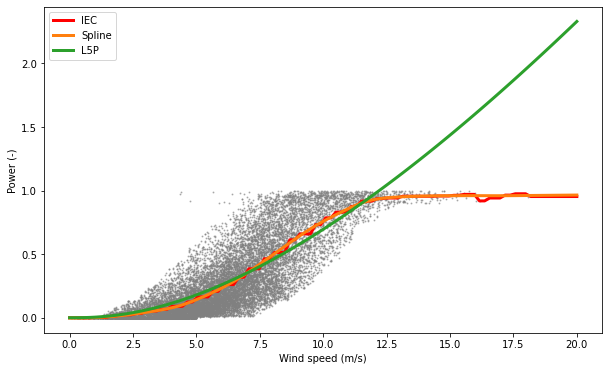

In [19]:
# Plot the results
x = np.linspace(0,20,100)
plt.figure(figsize = (10,6))
plt.scatter(windspeed_filt2, power_filt2, alpha=0.5, s = 1, c = 'gray')
plt.plot(x, iec_curve(x), color="red", label = 'IEC', linewidth = 3)
plt.plot(x, spline_curve(x), color="C1", label = 'Spline', linewidth = 3)
plt.plot(x, l5p_curve(x), color="C2", label = 'L5P', linewidth = 3)
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Power (-)')
plt.legend()
plt.show()

The spline model seems to fit the data best. Note that this model is in fact a straightforward forecast model that only requires the wind speed forecast at 100 m altitude.

The next step is to generate forecasts to conformalize using MAPIE. Of course, this means that we'll first have to divide the data set in a train and test set. Specifically, we fit a spline model on the first year (2012), use the first half year of 2013 as calibration set for conformalized mean regression and the last half year of 2013 as test data.

We'll do this in the next notebook!